In [1]:
import tensorflow as tf
import os
import imghdr
import cv2

import warnings
warnings.filterwarnings('ignore')

C:\Users\berid\AppData\Local\Temp\ipykernel_8364\983839058.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
os.path.join('csv_files','image_classification','images')

'csv_files\\image_classification\\images'

# Remove dodgy images

In [3]:
for img_class in ['happy','sad']:
    for img_file in os.listdir(os.path.join('csv_files','image_classification','images',img_class)):
        img_path=os.path.join('csv_files','image_classification','images',img_class,img_file)
        try:
            img=cv2.imread(img_path)
            tip=imghdr.what(img_path)
            if tip not in ['jpeg','jpg','png','bmp']:
                print(f'image not exists {img_file}')
                os.remove(img_path)
        except:
            print(f'issue with {img_file}')

# Load Data

In [4]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [5]:
data=tf.keras.utils.image_dataset_from_directory('csv_files/image_classification/images')

Found 557 files belonging to 2 classes.


# Preprocessing

In [6]:
data=data.map(lambda x,y:(x/255,y))

In [7]:
scaled_iterator=data.as_numpy_iterator()

In [8]:
batch=scaled_iterator.next()

In [9]:
batch[0].shape

(32, 256, 256, 3)

In [10]:
batch[1]

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0])

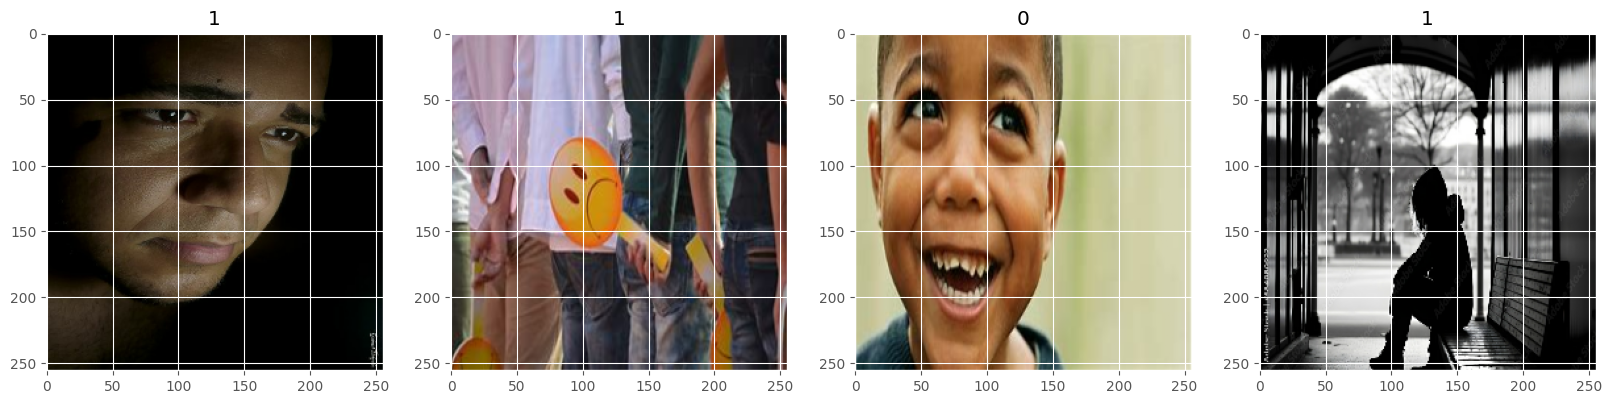

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# Splitting

In [12]:
len(data)

18

In [13]:
train_size,val_size,test_size=4,1,1

In [14]:
train_data=data.take(train_size)
val_data=data.skip(train_size).take(val_size)
test_data=data.skip(train_size+val_size).take(test_size)

In [15]:
print(len(train_data),len(val_data),len(test_data))

4 1 1


# Building Neural Network Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [17]:
model=Sequential()

In [18]:
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [19]:
model.compile(optimizer='adam',loss=tf._losses.BinaryCrossentropy(),metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# Training

In [21]:
logdir='csv_files/image_classification/model/logs'

In [22]:
tensorboard_callbacks=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [23]:
hist=model.fit(train_data,epochs=50,validation_data=val_data,callbacks=[tensorboard_callbacks])

Epoch 1/50




4/4 [==============================] - 7s 1s/step - loss: 0.8052 - accuracy: 0.5391 - val_loss: 0.6836 - val_accuracy: 0.5938
Epoch 2/50
4/4 [==============================] - 12s 4s/step - loss: 0.6892 - accuracy: 0.6250 - val_loss: 0.6702 - val_accuracy: 0.6562
Epoch 3/50
4/4 [==============================] - 27s 6s/step - loss: 0.6826 - accuracy: 0.5469 - val_loss: 0.6513 - val_accuracy: 0.7812
Epoch 4/50
4/4 [==============================] - 18s 4s/step - loss: 0.6623 - accuracy: 0.6953 - val_loss: 0.5889 - val_accuracy: 0.7188
Epoch 5/50
4/4 [==============================] - 6s 1s/step - loss: 0.5661 - accuracy: 0.7266 - val_loss: 0.6433 - val_accuracy: 0.6250
Epoch 6/50
4/4 [==============================] - 5s 1s/step - loss: 0.5124 - accuracy: 0.7422 - val_loss: 0.5407 - val_accuracy: 0.7812
Epoch 7/50
4/4 [==============================] - 5s 1s/step - loss: 0.4717 - accuracy: 0.7578 - val_loss: 0.4778 - val_accuracy: 0.7500
Epoch 8/50
4/4 [==============================]

# Visualize Training

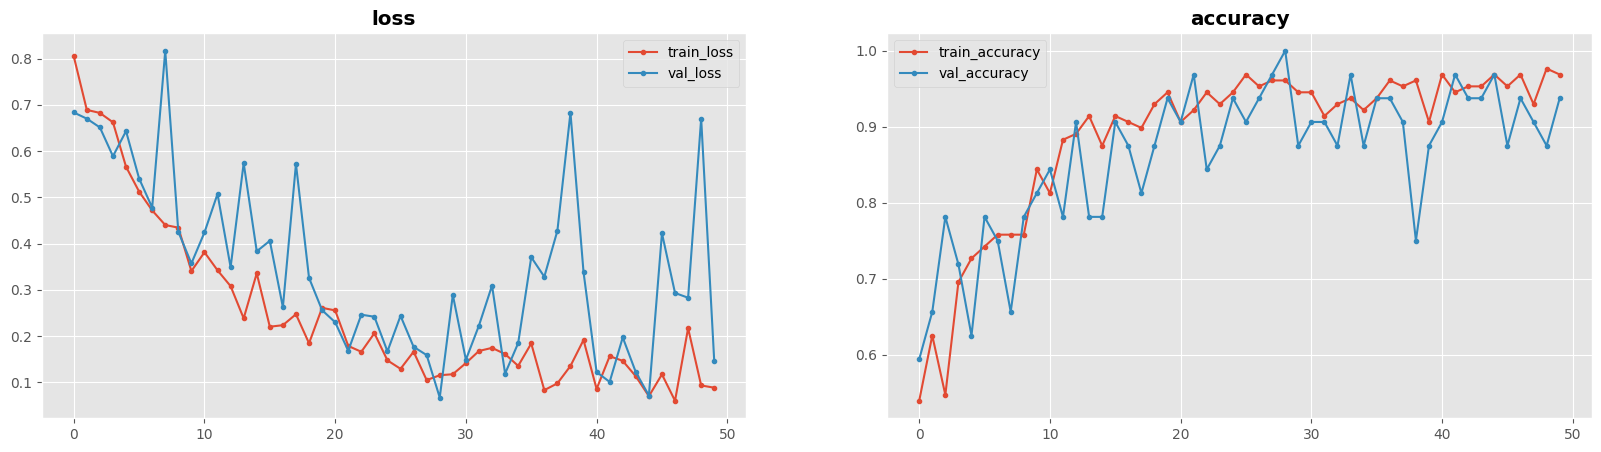

In [24]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))

ax1.plot(hist.history['loss'],label='train_loss',marker='.')
ax1.plot(hist.history['val_loss'],label='val_loss',marker='.')
ax1.set_title('loss',fontweight='bold')
ax1.legend()

ax2.plot(hist.history['accuracy'],label='train_accuracy',marker='.')
ax2.plot(hist.history['val_accuracy'],label='val_accuracy',marker='.')
ax2.set_title('accuracy',fontweight='bold')
ax2.legend()

plt.show()

# Testing on unseen images

In [25]:
from tensorflow.keras.metrics import Precision,Recall, BinaryAccuracy

In [26]:
for batch in test_data.as_numpy_iterator():
    X,y=batch
    y_test=model.predict(X)
    Precision().update_state(y,y_test)
    Recall().update_state(y,y_test)
    BinaryAccuracy().update_state(y,y_test)

1/1 [==============================] - 0s 182ms/step


In [27]:
print(Precision().result().numpy,Recall().result(),BinaryAccuracy().result())

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.0>> tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


1/1 [==============================] - 0s 30ms/step
[[0.17079559]]


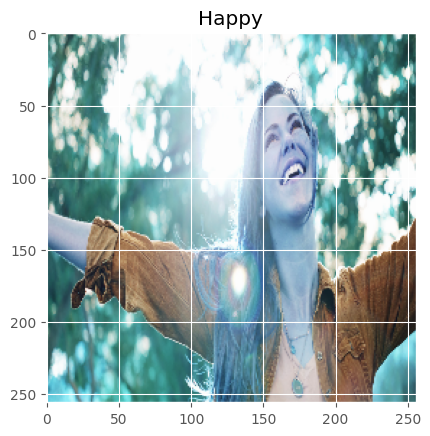

In [35]:
happy=cv2.imread(r"C:\Users\berid\python\csv_files\image_classification\images\happy woman.jpg")
happy=tf.image.resize(happy,(256,256))
prediction=model.predict(np.expand_dims(happy/255,0))

plt.imshow(happy.numpy().astype(int))
plt.title({0:'Happy',1:'Sad'}[prediction[0][0].round()])
print(prediction)

1/1 [==============================] - 0s 32ms/step
[[0.7881607]]


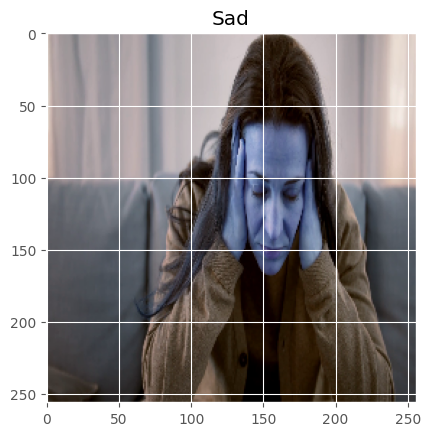

In [29]:
sad=cv2.imread(r"C:\Users\berid\python\csv_files\image_classification\images\i feel sad.png")
sad=tf.image.resize(sad,(256,256))
prediction=model.predict(np.expand_dims(sad/255,0))

plt.imshow(sad.numpy().astype(int))
plt.title({0:'Happy',1:'Sad'}[prediction[0][0].round()])
print(prediction)

1/1 [==============================] - 0s 38ms/step
[[0.3831667]]


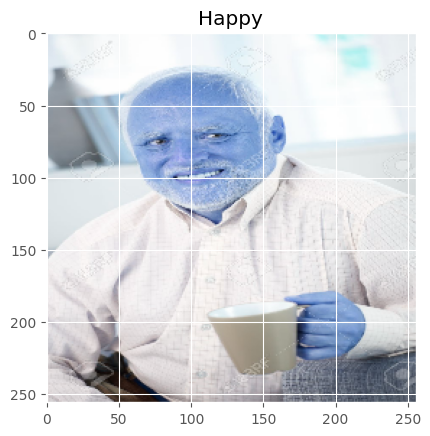

In [36]:
img=cv2.imread(r"C:\Users\berid\python\csv_files\image_classification\images\1freth.jpg")
img=tf.image.resize(img,(256,256))
prediction=loaded_model.predict(np.expand_dims(img/255,0))


plt.imshow(img.numpy().astype(int))
plt.title({0:'Happy',1:'Sad'}[prediction[0][0].round()])
print(prediction)

# Save Model

In [30]:
from tensorflow.keras.models import load_model

In [31]:
model.save('csv_files/image_classification/model/happy_sad_classification.h5')

In [32]:
loaded_model=load_model('csv_files/image_classification/model/happy_sad_classification.h5')